# Business Problem: 

###### The objective is predicting store sales using historical markdown data.It has historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

######  In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modelling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

###### For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):
        Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
        Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
        Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13 
        Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [100]:
#Import the necessary libaries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import scipy.stats as stats
import pandas_profiling  as pp 

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV

In [101]:
# Read the dataset:
stores= pd.read_csv('data/stores.csv')
features= pd.read_csv('data/features.csv')
train_data= pd.read_csv('data/train.csv')
test_data= pd.read_csv('data/test.csv')

In [102]:
print('********* stores ********')  
display(stores.info())
print('********* features **********')
display(features.info())
print('********* train_data **********')
display(train_data.info())
print('********* test_data **********')
display(test_data.info())

********* stores ********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


None

********* features **********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


None

********* train_data **********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


None

********* test_data **********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
Store        115064 non-null int64
Dept         115064 non-null int64
Date         115064 non-null object
IsHoliday    115064 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


None

In [103]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [104]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [105]:

train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [106]:
test_data.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [107]:
stores_feature= pd.merge(stores, features, how = 'inner', on= 'Store')   # deafult is inner join

In [108]:
train_stores_feature= pd.merge(train_data, stores_feature, how= 'inner') # deafult is inner join

In [109]:
train_stores_feature.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


#### Prepare a summary report for the merged train data set: 

In [110]:
train_stores_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [114]:
# train_profile= pp.ProfileReport(train_stores_feature, check_correlation=False, correlations={'pearson': False,
# 'spearman': False,
# 'kendall': False,
# 'phi_k': False,
# 'cramers': False,
# 'recoded': False})

In [115]:
train_stores_feature.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [116]:
train_stores_feature.shape

(421570, 16)

In [117]:
# merge the test data 
test_stores_feature= pd.merge(test_data, stores_feature, how= 'inner')
test_stores_feature.head()

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
2,1,3,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
3,1,4,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
4,1,5,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


In [118]:
test_stores_feature.shape

(115064, 15)

In [119]:
test_stores_feature.describe()

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,114915.000000,86437.000000,105235.000000,102176.000000,115064.000000,76902.000000,76902.000000
mean,22.238207,44.339524,136497.688921,53.941804,3.581546,7689.216439,3734.051729,2403.088666,3356.219071,3922.681189,176.961347,6.868733
std,12.809930,30.656410,61106.926438,18.724153,0.239442,10698.760716,8323.495014,13767.939313,7570.501545,19445.150745,41.239967,1.583427
min,1.000000,1.000000,34875.000000,-7.290000,2.872000,-2781.450000,-35.740000,-179.260000,0.220000,-185.170000,131.236226,3.684000
25%,11.000000,18.000000,93638.000000,39.820000,3.431000,1966.460000,180.350000,15.100000,155.460000,1309.300000,138.402033,5.771000
50%,22.000000,37.000000,140167.000000,54.470000,3.606000,4842.290000,742.590000,78.260000,840.940000,2390.430000,192.304445,6.806000
75%,33.000000,74.000000,202505.000000,67.350000,3.766000,9439.140000,2735.670000,272.580000,3096.920000,4227.270000,223.244532,8.036000
max,45.000000,99.000000,219622.000000,101.950000,4.125000,103184.980000,71074.170000,149483.310000,65344.640000,771448.100000,228.976456,10.199000


#### Data Pre-processing: 

In [120]:
# check for the null data
train_stores_feature.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

In [121]:
test_stores_feature.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64

As we can see that train data does not have null except markdown but the test data has null in 'CPI' and in 'Unemployment', we will treat the null values with 'mean'.

We can ignore Markdown imputation and can consider that there was no difference between the original retail sales price and the actual selling price in that store. Hence we will replace it with '0'.


In [122]:
# Check for missing values and impute the missing values with an appropriate value. (mean for continuous and mode for categorical)
test_stores_feature['CPI'] = test_stores_feature.groupby(['Dept'])['CPI'].transform(lambda x: x.fillna(x.mean()))
test_stores_feature['Unemployment'] = test_stores_feature.groupby(['Dept'])['Unemployment'].transform(lambda x: x.fillna(x.mean()))



In [123]:
test_stores_feature.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI                 0
Unemployment        0
dtype: int64

In [124]:
# Impute markdowns with '0'
test_stores_feature=test_stores_feature.fillna(0)
train_stores_feature=train_stores_feature.fillna(0)


#### EDA on train data

In [125]:
# check the stores wise sale 
store_count= train_stores_feature.groupby('Store')[['Store']].agg('count').add_prefix('Count_').reset_index()

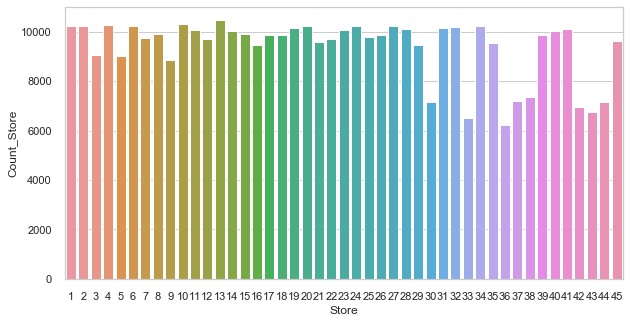

In [126]:
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
sns.barplot(x= 'Store', y= 'Count_Store', data= store_count)
plt.show()

It shows are there are maximum # of store 13.

In [127]:
# plt.figure(figsize=(10,5))
# sns.set(style="whitegrid")
# sns.lineplot(x= 'Weekly_Sales', y='Store' ,data= train_stores_feature)
# plt.show()


#### Store vs Weekly sales

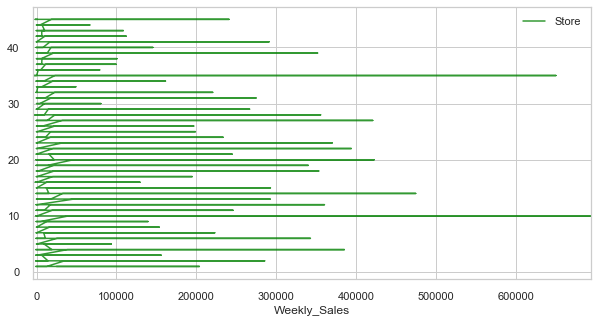

In [128]:
train_stores_feature.plot(kind='line', x='Weekly_Sales', y='Store', color='green' , alpha=0.8, figsize =(10,5))

Based on the above graph we can see that Store 10 is having the higest weekly sales followed by Store 35.

#### Weekly sales based on store types

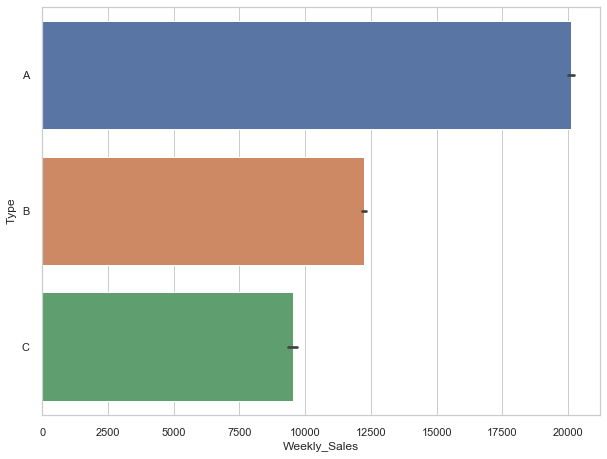

In [129]:
sns.barplot(x='Weekly_Sales', y='Type', data= train_stores_feature)
plt.show()

It shows that Store type 'A' is having the maximun weekly sale.

#### Weekly sales based on Dept

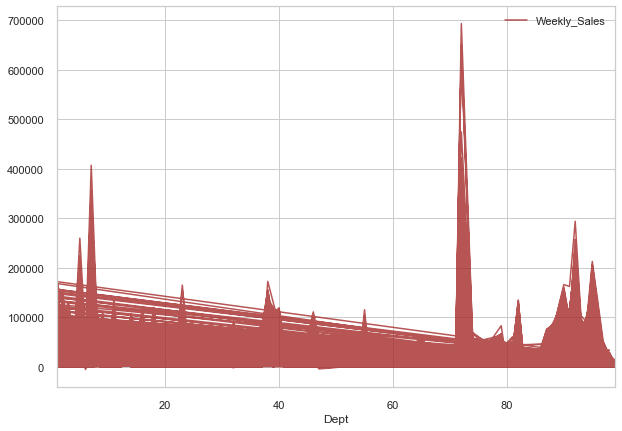

In [130]:
train_stores_feature.plot(kind='line', x='Dept', y='Weekly_Sales', color='brown' , alpha=0.8, figsize =(10,7))

#### Check the co-relation between the numerical variables in train and test

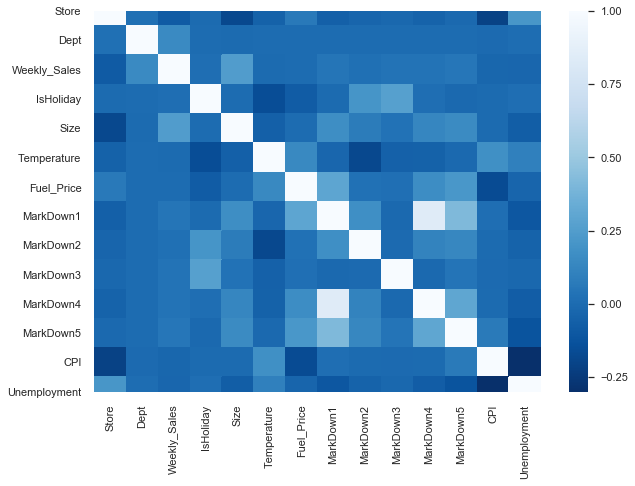

In [131]:
plt.figure(figsize=(10,7))
sns.heatmap(train_stores_feature.corr(), cmap='Blues_r')

We can see that, Markdown1 is highly co-related to Markdown4 in train data.

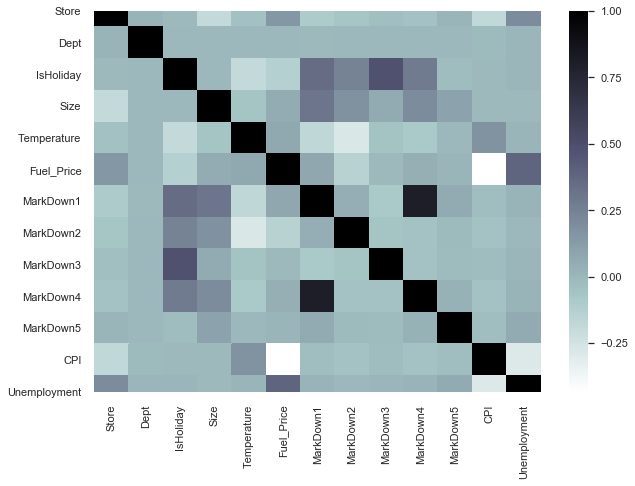

In [132]:
plt.figure(figsize=(10,7))
sns.heatmap(test_stores_feature.corr(), cmap='bone_r')

We can see that, Markdown1 is highly co-related to Markdown4 in test data as well.

#### Feature Engineering and variable reduction

We will indentify the categorial and numreical variables and conver the categorial data to numerical to apply ML algo.

In [133]:
train_stores_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       421570 non-null float64
MarkDown2       421570 non-null float64
MarkDown3       421570 non-null float64
MarkDown4       421570 non-null float64
MarkDown5       421570 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 71.9+ MB


In [134]:
train_stores_feature['Type'].value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [135]:
# Convert Type to Numerical var
train_stores_feature['Type']= np.where(train_stores_feature['Type'] == 'A', 1, 
                              np.where(train_stores_feature['Type'] == 'B', 2,3))

test_stores_feature['Type']= np.where(test_stores_feature['Type'] == 'A', 1, 
                              np.where(test_stores_feature['Type'] == 'B', 2,3))


In [136]:
# Convert Date to datetime
train_stores_feature['Date']=pd.to_datetime(train_stores_feature['Date'])
test_stores_feature['Date']= pd.to_datetime(test_stores_feature['Date'])

In [137]:
train_stores_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null int64
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       421570 non-null float64
MarkDown2       421570 non-null float64
MarkDown3       421570 non-null float64
MarkDown4       421570 non-null float64
MarkDown5       421570 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(10), int64(4)
memory usage: 71.9 MB


In [138]:
# Extract date features
train_stores_feature['Date_dayofweek'] =train_stores_feature['Date'].dt.dayofweek
train_stores_feature['Date_month'] =train_stores_feature['Date'].dt.month 
train_stores_feature['Date_year'] =train_stores_feature['Date'].dt.year
train_stores_feature['Date_day'] =train_stores_feature['Date'].dt.day 

test_stores_feature['Date_dayofweek'] =test_stores_feature['Date'].dt.dayofweek
test_stores_feature['Date_month'] =test_stores_feature['Date'].dt.month 
test_stores_feature['Date_year'] =test_stores_feature['Date'].dt.year
test_stores_feature['Date_day'] =test_stores_feature['Date'].dt.day 

In [139]:
train_stores_feature.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,False,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010,5
1,1,2,2010-02-05,50605.27,False,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010,5
2,1,3,2010-02-05,13740.12,False,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010,5
3,1,4,2010-02-05,39954.04,False,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010,5
4,1,5,2010-02-05,32229.38,False,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,2,2010,5


In [140]:
# Convert Boolean feature to number
train_stores_feature['IsHoliday']= np.where(train_stores_feature['IsHoliday'] =='False', 0,1)
test_stores_feature['IsHoliday']= np.where(test_stores_feature['IsHoliday'] =='False', 0,1)

As we dont have all the holidays listed in the data set, we will add those holidays in train and test data set.

 Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
 
 Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
 
 Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13 
 
 Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [141]:
from datetime import datetime
train_stores_feature['IsHoliday']= np.where(
                                (train_stores_feature['Date'] == datetime.strptime("12-Feb-10","%d-%b-%y"))|
                                (train_stores_feature['Date'] == datetime.strptime("11-Feb-11","%d-%b-%y"))|  
                                (train_stores_feature['Date'] == datetime.strptime("10-Feb-12","%d-%b-%y"))|
                                (train_stores_feature['Date'] == datetime.strptime("8-Feb-13","%d-%b-%y"))|      # Super Bowl
                                (train_stores_feature['Date'] == datetime.strptime("10-Sep-10","%d-%b-%y"))|
                                (train_stores_feature['Date'] == datetime.strptime("9-Sep-11","%d-%b-%y"))|  
                                (train_stores_feature['Date'] == datetime.strptime("7-Sep-12","%d-%b-%y"))|
                                (train_stores_feature['Date'] == datetime.strptime("6-Sep-13","%d-%b-%y"))|    # Labor Day
                                (train_stores_feature['Date'] == datetime.strptime("26-Nov-10","%d-%b-%y"))|
                                (train_stores_feature['Date'] == datetime.strptime("25-Nov-11","%d-%b-%y"))|  
                                (train_stores_feature['Date'] == datetime.strptime("23-Nov-12","%d-%b-%y"))|
                                (train_stores_feature['Date'] == datetime.strptime("29-Nov-13","%d-%b-%y"))|   # Thanksgiving
                                (train_stores_feature['Date'] == datetime.strptime("31-Dec-10","%d-%b-%y"))|
                                (train_stores_feature['Date'] == datetime.strptime("30-Dec-11","%d-%b-%y"))|  
                                (train_stores_feature['Date'] == datetime.strptime("28-Dec-12","%d-%b-%y"))|  
                                (train_stores_feature['Date'] == datetime.strptime("27-Dec-13","%d-%b-%y")), 1,0) #Christmas


In [142]:
train_stores_feature.IsHoliday.value_counts()

0    391909
1     29661
Name: IsHoliday, dtype: int64

In [143]:
test_stores_feature['IsHoliday']= np.where(
                                (test_stores_feature['Date'] == datetime.strptime("12-Feb-10","%d-%b-%y"))|
                                (test_stores_feature['Date'] == datetime.strptime("11-Feb-11","%d-%b-%y"))|  
                                (test_stores_feature['Date'] == datetime.strptime("10-Feb-12","%d-%b-%y"))|
                                (test_stores_feature['Date'] == datetime.strptime("8-Feb-13","%d-%b-%y"))|      # Super Bowl
                                (test_stores_feature['Date'] == datetime.strptime("10-Sep-10","%d-%b-%y"))|
                                (test_stores_feature['Date'] == datetime.strptime("9-Sep-11","%d-%b-%y"))|  
                                (test_stores_feature['Date'] == datetime.strptime("7-Sep-12","%d-%b-%y"))|
                                (test_stores_feature['Date'] == datetime.strptime("6-Sep-13","%d-%b-%y"))|    # Labor Day
                                (test_stores_feature['Date'] == datetime.strptime("26-Nov-10","%d-%b-%y"))|
                                (test_stores_feature['Date'] == datetime.strptime("25-Nov-11","%d-%b-%y"))|  
                                (test_stores_feature['Date'] == datetime.strptime("23-Nov-12","%d-%b-%y"))|
                                (test_stores_feature['Date'] == datetime.strptime("29-Nov-13","%d-%b-%y"))|   # Thanksgiving
                                (test_stores_feature['Date'] == datetime.strptime("31-Dec-10","%d-%b-%y"))|
                                (test_stores_feature['Date'] == datetime.strptime("30-Dec-11","%d-%b-%y"))|  
                                (test_stores_feature['Date'] == datetime.strptime("28-Dec-12","%d-%b-%y"))|  
                                (test_stores_feature['Date'] == datetime.strptime("27-Dec-13","%d-%b-%y")), 1,0) #Christmas


In [144]:
test_stores_feature.IsHoliday.value_counts()

0    106136
1      8928
Name: IsHoliday, dtype: int64

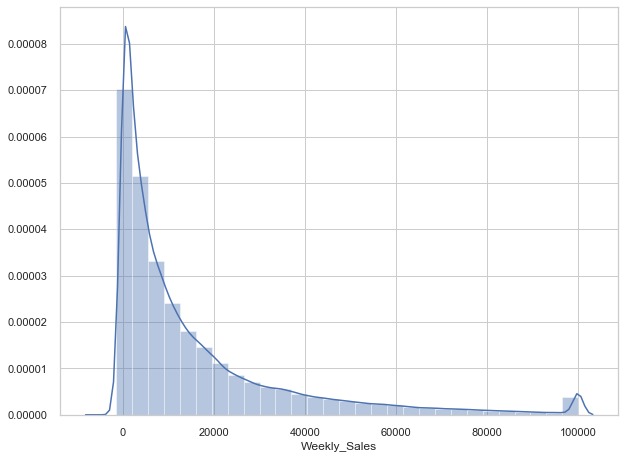

In [145]:
# check the dis plt of weekly sales and treat outliers
train_stores_feature.Weekly_Sales=np.where(train_stores_feature.Weekly_Sales>100000, 100000,train_stores_feature.Weekly_Sales)
sns.distplot(train_stores_feature.Weekly_Sales, bins =30)

#### Feature Selection:

In [146]:
train_stores_feature.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
Store             421570 non-null int64
Dept              421570 non-null int64
Date              421570 non-null datetime64[ns]
Weekly_Sales      421570 non-null float64
IsHoliday         421570 non-null int64
Type              421570 non-null int64
Size              421570 non-null int64
Temperature       421570 non-null float64
Fuel_Price        421570 non-null float64
MarkDown1         421570 non-null float64
MarkDown2         421570 non-null float64
MarkDown3         421570 non-null float64
MarkDown4         421570 non-null float64
MarkDown5         421570 non-null float64
CPI               421570 non-null float64
Unemployment      421570 non-null float64
Date_dayofweek    421570 non-null int64
Date_month        421570 non-null int64
Date_year         421570 non-null int64
Date_day          421570 non-null int64
dtypes: datetime64[ns](1), float64(10), int64(9)
memory usag

In [147]:
# Dropping date as we have already convereted date to int.
train_stores_feature.drop(columns= 'Date', inplace= True)

In [148]:
# define dataset
train_X = train_stores_feature[train_stores_feature.columns.difference(['Weekly_Sales'])]
train_y = train_stores_feature['Weekly_Sales']

test_X = test_stores_feature
test_X=test_stores_feature.drop('Date',axis=1).copy()
print(train_X.shape, train_y.shape, test_stores_feature.shape)

(421570, 18) (421570,) (115064, 19)


In [149]:
# To select the best features we will use, RFE technique(Recursive Feature Elimination)
#RFE
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import RandomForestRegressor

# rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=10)
# rfe = rfe.fit(X, y)

# X.columns[rfe.get_support()]

##### Linear Regression

In [150]:
## Methood 1..
model = LinearRegression()
model.fit(train_X, train_y)

y_pred_linear = model.predict(test_X)

acc_linear=round( model.score(train_X, train_y) * 100, 2)

print ('score:'+str(acc_linear) + ' percent')

score:8.99 percent


#### Decison Tree

In [151]:
model=DecisionTreeRegressor()
model.fit(train_X, train_y)
y_pred_dt= model.predict(test_X)
acc_dt = round( model.score(train_X, train_y) * 100, 2)
print ('score:' +str(acc_dt) + ' percent')

score:100.0 percent


#### Random Forest

In [152]:
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor 

In [153]:
model = RandomForestRegressor(n_estimators=50)
model.fit(train_X, train_y)

y_pred_rf=model.predict(test_X)

acc_rf= round(model.score(train_X, train_y) * 100, 2)
print ("Accuracy: %i %% \n"%acc_rf)

Accuracy: 99 % 



##### AdaBoost 

In [154]:
model=AdaBoostRegressor(learning_rate = 0.1, n_estimators=50)
model.fit(train_X, train_y )

AdaBoostRegressor(learning_rate=0.1)

In [155]:
y_pred_ad=model.predict(test_X)

acc_ad= round(model.score(train_X, train_y) * 100, 2)
print ("Accuracy: %i %% \n"%acc_ad)

Accuracy: 41 % 



In [156]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Decision Tree', 'Random Forest', 'AdaBoost'],
    'Score': [acc_linear,acc_dt,acc_rf, acc_ad ]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
1,Decision Tree,100.00
2,Random Forest,99.76
3,AdaBoost,41.52
0,Linear Regression,8.99


#### Predicting weely sales for test data: 

Based on the above results , we can see the good accuracy is coming with RandomForest model. As Decesion Tree giving 100% accuracy, it is overfitting.So we will use RandomForest to predict weekly sales for test data.


In [157]:
# Prediction value using Random Forest model..
FinalSubmission = pd.DataFrame({
        "Store_Dept_Date": test_stores_feature.Store.astype(str)+'_'+test_stores_feature.Dept.astype(str)+'_'+test_stores_feature.Date.astype(str),
        "Weekly_Sales": y_pred_rf
    })
FinalSubmission.to_csv('weekly_sales predicted.csv', index=False)


In [158]:
FinalSubmission

,Store_Dept_Date,Weekly_Sales
0,1_1_2012-11-02,7326.3720
1,1_2_2012-11-02,7326.3720
2,1_3_2012-11-02,7326.3720
3,1_4_2012-11-02,7326.3720
4,1_5_2012-11-02,7326.3720
...,...,...
115059,45_93_2013-07-26,420.7142
115060,45_94_2013-07-26,420.7142
115061,45_95_2013-07-26,420.7142
115062,45_97_2013-07-26,420.7142
